# Overview

In this analysis, we measure how well players convert an advantage, as measured by the computer evaluation.

For instance, we would expect a player to obtain roughly 50% of all available points if they have an equal position against a similarly-rated player. But this percentage will increase if they are higher-rated than their opponent.

I find that, if you are playing against someone who is 300 points lower-rated than you, and you are in a losing position (-2), then you're still expected to get more than 50% of points!

The impact of the rating on the win percentage is not strongly affected by player quality, the effects are similarly strong for a large open tournament (Rejkjavik Open 2018) and super tournaments.

# Setup

In [208]:
import pandas as pd
import numpy as np
import psycopg2
import pandas.io.sql as sqlio
import statsmodels.formula.api as smf
import imp

In [209]:
import queries
import functions as f
imp.reload(f); imp.reload(queries)

<module 'queries' from '/Users/cg/Dropbox/research/chess/queries.py'>

In [210]:
pd.set_option('precision', 2) 
pd.set_option('display.width', 200)

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [211]:
conn = psycopg2.connect(f.CONNSTRING)

# Data cleaning

We look only at moves between move 10 and 40 of a game. Thus we exclude moves in which most players are still in book and also long endgames which provide a lot of observations, but little change in the status of the game.

In [217]:
params = {
    'move_number_start': 10,
    'move_number_end': 40
}

In [218]:
df = sqlio.read_sql_query(queries.q_rating, conn, params=params) 
df.shape

(39552, 6)

## Summary statistics

### Number of observations 

In [219]:
df.db_name.value_counts()

Rejkjavik Open 2018                   23439
Candidates 2011-2018                   5916
Wijk An Zee (Tata Steel) 2012-2018     5193
Supertournaments 2017                  4461
World Championships 1886-2014           543
Name: db_name, dtype: int64

In [220]:
df['difference'] = df.rating_own - df.rating_opponent 
df['result'] = df.win + 0.5 * df.draw

### Standard deviation of rating difference
The standard deviation is much smaller in elite tournaments than in opens:

In [221]:
df.groupby('db_name').difference.std()

db_name
Candidates 2011-2018                   35.01
Rejkjavik Open 2018                   321.80
Supertournaments 2017                  61.70
Wijk An Zee (Tata Steel) 2012-2018     87.20
World Championships 1886-2014          82.67
Name: difference, dtype: float64

## Data cleaning

Creating a grouped variable for the rating difference

In [222]:
df['difference_group'] = round(df.difference / 200)
diff_max = 3
df.loc[df.difference_group < -diff_max, 'difference_group'] = -diff_max
df.loc[df.difference_group > diff_max, 'difference_group'] = diff_max

df['eval_group'] = round(df.ev / 100)

# Summarizing the data

In [223]:
df_rejkjavik = df.query('db_name == "Rejkjavik Open 2018"')

In [224]:
means = pd.DataFrame(
     df_rejkjavik
    .query('-3 <= eval_group <= 3')
    .groupby(['difference_group', 'eval_group'])
    .result
    .mean()
)
counts = (df_rejkjavik
  .query('-3 <= eval_group <= 3')
  .groupby(['difference_group', 'eval_group'])
  .result
  .count())

means['counts'] = counts  
means = means.query('counts >= 10 and difference_group >= 0')
del means['counts']

In [225]:
table = means.unstack(0)   
table.index = [int(v) for v in table.index]
def group_name(v):
    return '%s to %s' % (v*200-100, v*200+100)
table.columns = [group_name(v) for v in table.columns.get_level_values(1)]

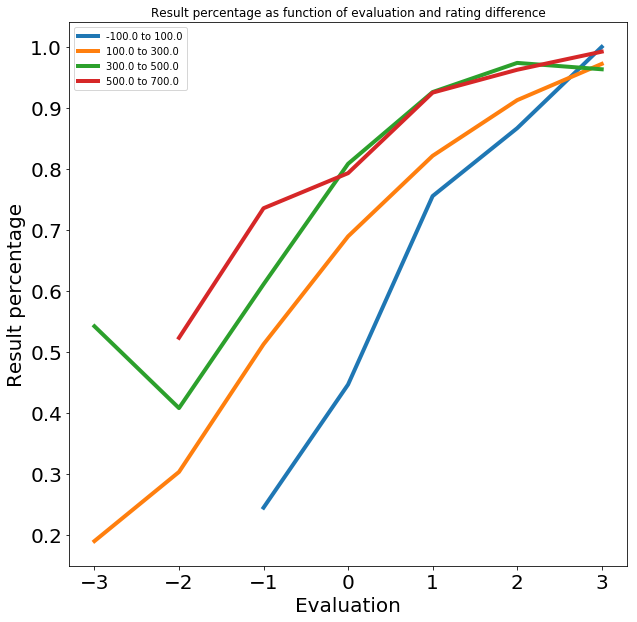

In [249]:
fig, ax = plt.subplots()
ax.set_xlabel("Evaluation", fontsize=20)
ax.set_ylabel("Result percentage", fontsize=20)
settings = {
    'title': "Result percentage as function of evaluation and rating difference",
    'fontsize': 20,
    'legend': True,
    'figsize': (10, 10),
    'lw': 4,
    'ax': ax
}
table.plot(**settings)

The graph shows the expected result percentage as a function of the position evaluation and the rating difference to the opponent.

For instance, we find that, if you play against someone who is 400 points lower-rated then you and your evaluation is -3, then you are still obtaining more than 50% of the points.

Note, however, that this is just one point on this graph. To quantify this by summarizing all the data, we work with a linear regression, below. 

The same data in table format

In [227]:
table

,-100.0 to 100.0,100.0 to 300.0,300.0 to 500.0,500.0 to 700.0
-3,NaN,0.19,0.54,NaN
-2,NaN,0.30,0.41,0.52
-1,0.24,0.51,0.61,0.74
0,0.45,0.69,0.81,0.79
1,0.76,0.82,0.93,0.93
2,0.87,0.91,0.97,0.96
3,1.00,0.97,0.96,0.99


## Quantifying the rating-evaluation tradeoff
We know try to quantify these effects and calculate the tradeoff between player rating and the position evaluation. We do this using a linear regression.

Creating helper variables that are scaled, which gives us nicer regression coefficients.

In [228]:
df['rating_own_small'] = df.rating_own / 100
df['rating_opponent_small'] = df.rating_opponent / 100
df['diff_small'] = df.difference / 100
df['eval_small'] = df.ev / 100

In [229]:
df_rejkjavik = df.query('db_name == "Rejkjavik Open 2018"')

In [230]:
reg = smf.ols('result ~ eval_small + diff_small', data=df_rejkjavik.query('-5 <= eval_small <= 5')).fit()
params = reg.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 result   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                 1.012e+04
Date:                Wed, 11 Jul 2018   Prob (F-statistic):               0.00
Time:                        10:02:59   Log-Likelihood:                -5863.9
No. Observations:               22262   AIC:                         1.173e+04
Df Residuals:                   22259   BIC:                         1.176e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5085      0.002    240.728      0.000       0.504       0.513
eval_small     0.0962      0.002     61.537      0.000       0.093       0.099
diff_small     0.0679      0.001     94.528      0.000       0.066       0.069
==============================================================================
Omnibus:                        3.146   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                3.154
Skew:                           0.023   Prob(JB):                        0.207
Kurtosis:                       2.964   Cond. No.                         3.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To check for a non-linear effect, I include a squared term in the regression. The coefficient is very small and not even statistically significant, which suggests that the non-linear effect is relatively small.

In [251]:
reg = smf.ols('result ~ eval_small + I(eval_small*eval_small) + diff_small', data=df_rejkjavik.query('-5 <= eval_small <= 5')).fit()
params = reg.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 result   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     6749.
Date:                Wed, 11 Jul 2018   Prob (F-statistic):               0.00
Time:                        10:15:09   Log-Likelihood:                -5863.5
No. Observations:               22262   AIC:                         1.173e+04
Df Residuals:                   22258   BIC:                         1.177e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.5075      0.002    213.670      0.000       0.503       0.512
eval_small                     0.0962      0.002     61.527      0.000       0.093       0.099
I(eval_small * eval_small)     0.0005      0.001      0.926      0.355      -0.001       0.001
diff_small                     0.0679      0.001     94.505      0.000       0.066       0.069
==============================================================================
Omnibus:                        3.880   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                3.880
Skew:                           0.026   Prob(JB):                        0.144
Kurtosis:                       2.961   Cond. No.                         5.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [231]:
value_of_100_rating = params['diff_small'] / params['eval_small']
print("Value of 100 rating points: %0.2f" % value_of_100_rating)

Value of 100 rating points: 0.71


In [232]:
df_value = pd.DataFrame()
df_value['rating_difference'] = np.arange(0, 400, 100)
df_value['evaluation'] = -(df_value.rating_difference * value_of_100_rating)/100

### Required evaluation to get result of 50% against a player
Note that this is a linear interpolation from the linear regression, this is not directly from the raw data.

In [233]:
df_value.set_index('rating_difference')

,evaluation
rating_difference,
0,-0.00
100,-0.71
200,-1.41
300,-2.12


# Comparison to super-tournaments

In [234]:
df_super = df.query('db_name == "Supertournaments 2017"')
reg_super = smf.ols('result ~ eval_small + diff_small', data=df_super.query('-5 <= eval_small <= 5')).fit()
params_super = reg_super.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 result   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                 1.012e+04
Date:                Wed, 11 Jul 2018   Prob (F-statistic):               0.00
Time:                        10:03:02   Log-Likelihood:                -5863.9
No. Observations:               22262   AIC:                         1.173e+04
Df Residuals:                   22259   BIC:                         1.176e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5085      0.002    240.728      0.000       0.504       0.513
eval_small     0.0962      0.002     61.537      0.000       0.093       0.099
diff_small     0.0679      0.001     94.528      0.000       0.066       0.069
==============================================================================
Omnibus:                        3.146   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                3.154
Skew:                           0.023   Prob(JB):                        0.207
Kurtosis:                       2.964   Cond. No.                         3.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [235]:
value_of_100_rating = params_super['diff_small'] / params_super['eval_small']
print("Value of 100 rating points: %0.2f" % value_of_100_rating)

Value of 100 rating points: 0.59


We find that, for elite players, the impact of rating on the result percentage is only a little smaller (0.6 vs 0.7) compared to amateur players at a big open.